In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [19]:
dout = "preselections/"

In [12]:
signal_trees = TreeIter(list(map(Tree,fc.eightb.accstudies_no_pu.signal_list)))
signal_trees_pu = TreeIter(list(map(Tree,fc.eightb.accstudies.signal_list)))

In [13]:
def get_point(label):
    label = label.split('_')
    return str((int(label[1]),int(label[3])))
signal_points = list(map(get_point,signal_trees.sample))

In [60]:
def n_jet_diff(tree):
    return {'n_jet_diff':tree.n_total_jet-tree.n_jet}

def count_jets(tree):
    return dict(n_jet_signal=ak.sum(tree.jet_signalId > -1,axis=-1),n_jet_ext=ak.sum(tree.jet_signalId == -1,axis=-1))

def njet8_efficiency(tree):
    return ak.sum(tree.n_jet >= 8)/ak.count(tree.n_jet)

In [30]:
def graph_signal_means(trees,trees_pu,variable,xlabel,**kwargs):
    array = np.array([ get_avg_std(t[variable]) for t in trees ])
    array_pu = np.array([ get_avg_std(t[variable]) for t in trees_pu ])
    graph_multi(signal_points,[array[:,0],array_pu[:,0]],labels=["No PU","With PU"],xlabel=signal_points,ylabel=xlabel,**kwargs)
    

In [47]:
def graph_njet8_efficiency(trees,trees_pu,**kwargs):
    efficiency = np.array(trees.apply(njet8_efficiency))
    efficiency_pu = np.array(trees_pu.apply(njet8_efficiency))
    return graph_multi(signal_points,[efficiency,efficiency_pu],labels=["No PU","With PU"],ylabel='N Jet $\geq 8$ Efficiency',xlabel=signal_points,ylim=(0.50,1.1),grid=True,**kwargs)

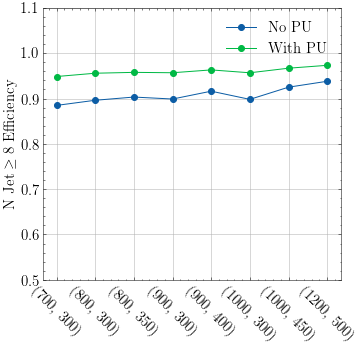

In [57]:
trees = signal_trees
trees_pu = signal_trees_pu
treeiter = TreeIter([trees[-2],trees_pu[-2]])
title = 'Jet $P_{T}>20$ GeV'

varlist = ['n_jet','n_jet_signal','n_jet_ext']
xlabels = ['N Jets','N Jets Signal Matched','N Jets Unmatched']

study.quick(
    treeiter,
    varlist=varlist,
    scale=False,
    labels=["No PU","With PU"],
    s_colors=[None],
    dim=(-1,4),
    title=title,
    xlabels=xlabels
)


fig,axs = plt.subplots(ncols=4,figsize=(16*4/3,5))
for i,(var,xlabel) in enumerate(zip(varlist,xlabels)):
    graph_signal_means(trees,trees_pu,var,xlabel,ylim=(0,12),grid=True,figax=(fig,axs[i]))
graph_njet8_efficiency(trees,trees_pu,figax=(fig,axs[3]))

fig.suptitle(title)
fig.tight_layout()

study.quick(
    treeiter,
    varlist=['jet_pt','jet_eta','jet_phi','jet_btag'],
    s_colors=None,
    labels=['No PU','With PU'], 
    scale=False, 
    ratio=True,
    title=title,
    dim=(-1,4),
)


In [18]:
njet8 = EventFilter('njet8',n_jet_emin=8)

njet8_trees = njet8.filter(signal_trees)
njet8_trees_pu = njet8.filter(signal_trees_pu)

In [20]:
(njet8_trees + njet8_trees_pu).extend(kwargs=lambda t : dict(
    n_total_jet=t.n_jet, 
    jet_abseta = np.abs(t.jet_eta)
));

In [23]:
def pu_decision(jets): return (jets.jet_pt > 50) | (((jets.jet_puid >> 1)&1) == 1)

In [24]:
jetpt20 = CollectionFilter('jet',pt_emin=20)
jeteta24= CollectionFilter('jet',eta_abs_emax=2.4)
jettight= CollectionFilter('jet',id_bit=1)
jetpuid = CollectionFilter('jet',filter=pu_decision)

In [25]:
varinfo.clear()

In [61]:
cut = jetpt20
jetpt20_trees = cut.filter(njet8_trees)
jetpt20_trees_pu = cut.filter(njet8_trees_pu)
(jetpt20_trees + jetpt20_trees_pu).extend(kwargs=count_jets);

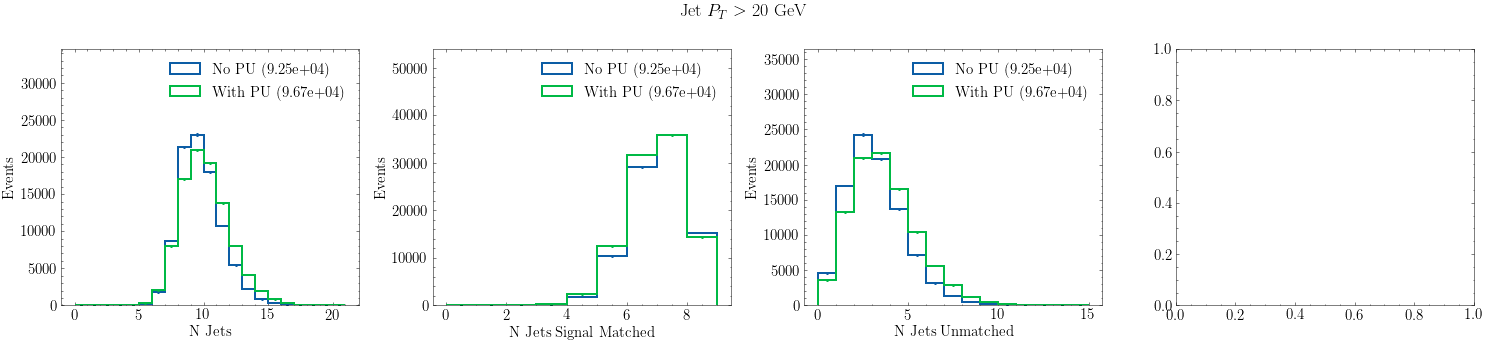

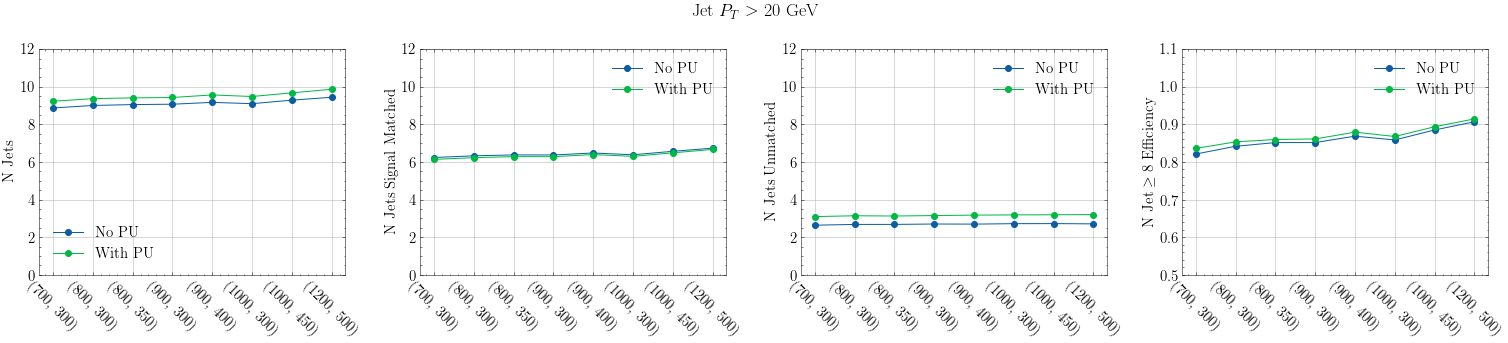

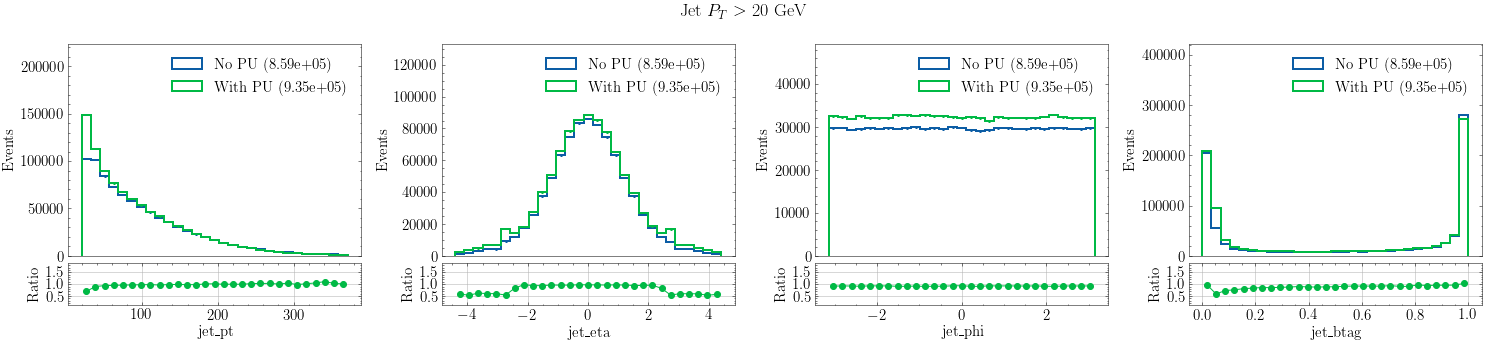

In [65]:
trees = jetpt20_trees 
trees_pu = jetpt20_trees_pu
treeiter = TreeIter([trees[-2],trees_pu[-2]])
title = 'Jet $P_{T}>20$ GeV'

varlist = ['n_jet','n_jet_signal','n_jet_ext']
xlabels = ['N Jets','N Jets Signal Matched','N Jets Unmatched']

study.quick(
    treeiter,
    varlist=varlist,
    scale=False,
    labels=["No PU","With PU"],
    s_colors=[None],
    dim=(-1,4),
    title=title,
    xlabels=xlabels
)


fig,axs = plt.subplots(ncols=4,figsize=(16*4/3,5))
for i,(var,xlabel) in enumerate(zip(varlist,xlabels)):
    graph_signal_means(trees,trees_pu,var,xlabel,ylim=(0,12),grid=True,figax=(fig,axs[i]))
graph_njet8_efficiency(trees,trees_pu,figax=(fig,axs[3]))

fig.suptitle(title)
fig.tight_layout()

study.quick(
    treeiter,
    varlist=['jet_pt','jet_eta','jet_phi','jet_btag'],
    s_colors=None,
    labels=['No PU','With PU'], 
    scale=False, 
    ratio=True,
    title=title,
    dim=(-1,4),
)


In [206]:
cut = jeteta24
trees = cut.filter(signal_trees)
trees_pu = cut.filter(signal_trees_pu)
trees.extend(kwargs=n_jet_diff)
trees_pu.extend(kwargs=n_jet_diff)

[None, None, None, None, None, None, None, None]

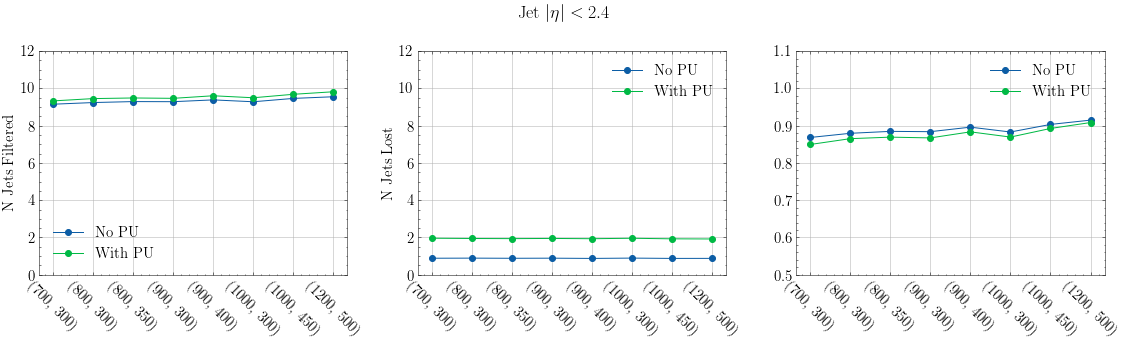

In [207]:
fig,axs = plt.subplots(ncols=3,figsize=(16,5))
for i,(var,xlabel) in enumerate(zip(varlist,xlabel)):
    array = np.array([ get_avg_std(t[var]) for t in trees ])
    array_pu = np.array([ get_avg_std(t[var]) for t in trees_pu ])
    graph_multi(signal_points,[array[:,0],array_pu[:,0]],labels=["No PU","With PU"],xlabel=signal_points,ylabel=xlabel,ylim=(0,12),grid=True,figax=(fig,axs[i]))
    

efficiency = trees.apply(njet8_efficiency)
efficiency_pu = trees_pu.apply(njet8_efficiency)
graph_multi(signal_points,[efficiency,efficiency_pu],labels=["No PU","With PU"],xlabel=signal_points,ylim=(0.50,1.1),grid=True,figax=(fig,axs[2]))

fig.suptitle('Jet $|\eta| < 2.4$')
fig.tight_layout()

In [208]:
varlist=['n_jet','n_jet_diff']
xlabel=['N Jets Filtered','N Jets Lost']

cut = FilterSequence(jetpt20,jeteta24)
trees = cut.filter(signal_trees)
trees_pu = cut.filter(signal_trees_pu)
trees.extend(kwargs=n_jet_diff)
trees_pu.extend(kwargs=n_jet_diff)

[None, None, None, None, None, None, None, None]

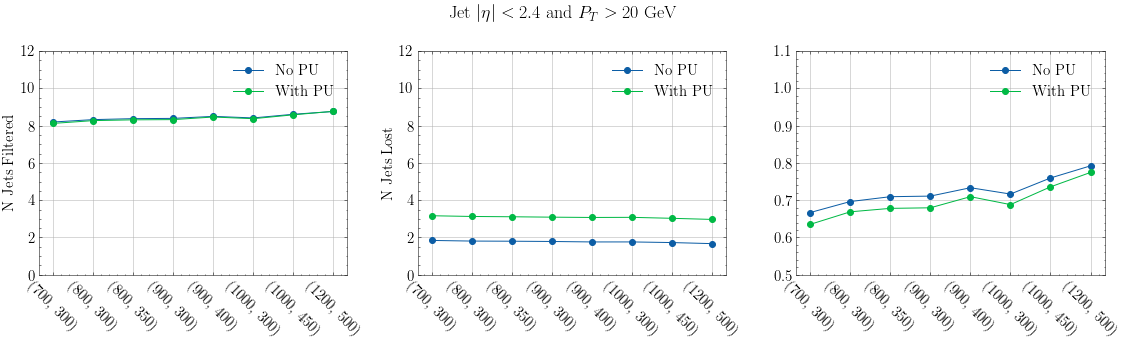

In [209]:
fig,axs = plt.subplots(ncols=3,figsize=(16,5))
for i,(var,xlabel) in enumerate(zip(varlist,xlabel)):
    array = np.array([ get_avg_std(t[var]) for t in trees ])
    array_pu = np.array([ get_avg_std(t[var]) for t in trees_pu ])
    graph_multi(signal_points,[array[:,0],array_pu[:,0]],labels=["No PU","With PU"],xlabel=signal_points,ylabel=xlabel,ylim=(0,12),grid=True,figax=(fig,axs[i]))
    

efficiency = trees.apply(njet8_efficiency)
efficiency_pu = trees_pu.apply(njet8_efficiency)
graph_multi(signal_points,[efficiency,efficiency_pu],labels=["No PU","With PU"],xlabel=signal_points,ylim=(0.50,1.1),grid=True,figax=(fig,axs[2]))

fig.suptitle('Jet $|\eta| < 2.4$ and $P_{T}>20$ GeV')
fig.tight_layout()

In [210]:
varlist=['n_jet','n_jet_diff']
xlabel=['N Jets Filtered','N Jets Lost']

cut = FilterSequence(jetpt20,jeteta24,jettight)
trees = cut.filter(signal_trees)
trees_pu = cut.filter(signal_trees_pu)
trees.extend(kwargs=n_jet_diff)
trees_pu.extend(kwargs=n_jet_diff)

[None, None, None, None, None, None, None, None]

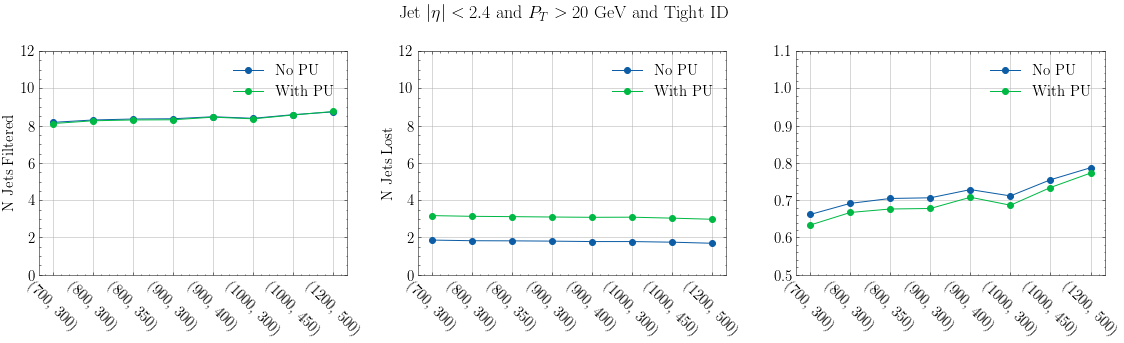

In [211]:
fig,axs = plt.subplots(ncols=3,figsize=(16,5))
for i,(var,xlabel) in enumerate(zip(varlist,xlabel)):
    array = np.array([ get_avg_std(t[var]) for t in trees ])
    array_pu = np.array([ get_avg_std(t[var]) for t in trees_pu ])
    graph_multi(signal_points,[array[:,0],array_pu[:,0]],labels=["No PU","With PU"],xlabel=signal_points,ylabel=xlabel,ylim=(0,12),grid=True,figax=(fig,axs[i]))
    

efficiency = trees.apply(njet8_efficiency)
efficiency_pu = trees_pu.apply(njet8_efficiency)
graph_multi(signal_points,[efficiency,efficiency_pu],labels=["No PU","With PU"],xlabel=signal_points,ylim=(0.50,1.1),grid=True,figax=(fig,axs[2]))

fig.suptitle('Jet $|\eta| < 2.4$ and $P_{T}>20$ GeV and Tight ID')
fig.tight_layout()

In [212]:
varlist=['n_jet','n_jet_diff']
xlabel=['N Jets Filtered','N Jets Lost']

cut = FilterSequence(jetpt20,jeteta24,jettight,jetpuid)
trees = cut.filter(signal_trees)
trees_pu = cut.filter(signal_trees_pu)
trees.extend(kwargs=n_jet_diff)
trees_pu.extend(kwargs=n_jet_diff)

[None, None, None, None, None, None, None, None]

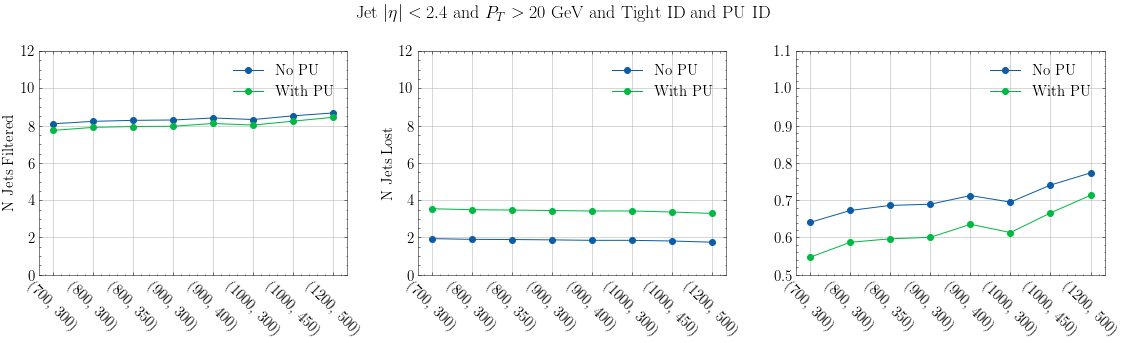

In [213]:
fig,axs = plt.subplots(ncols=3,figsize=(16,5))
for i,(var,xlabel) in enumerate(zip(varlist,xlabel)):
    array = np.array([ get_avg_std(t[var]) for t in trees ])
    array_pu = np.array([ get_avg_std(t[var]) for t in trees_pu ])
    graph_multi(signal_points,[array[:,0],array_pu[:,0]],labels=["No PU","With PU"],xlabel=signal_points,ylabel=xlabel,ylim=(0,12),grid=True,figax=(fig,axs[i]))
    

efficiency = trees.apply(njet8_efficiency)
efficiency_pu = trees_pu.apply(njet8_efficiency)
graph_multi(signal_points,[efficiency,efficiency_pu],labels=["No PU","With PU"],xlabel=signal_points,ylim=(0.50,1.1),grid=True,figax=(fig,axs[2]))

fig.suptitle('Jet $|\eta| < 2.4$ and $P_{T}>20$ GeV and Tight ID and PU ID')
fig.tight_layout()